# Analysis of Day Ahead Electricity Prices TimeSeries

## 0.1 Imports of needed libraries:

In [57]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from battery_optimization.data_handler import DataHandler

## 0.2 Loading the processed data. 

Dataset consists in two timeseries containing the prices for electricity from the first 6 months of 2022. The 15 min data contains prices for 15 minutes contracts. The 60 min data is for 60 minutes contracts.

In [3]:
dh = DataHandler(reprocess=False)

18-Mar-23 20:36:33 - Processing csv file: Day-ahead_Prices_60min.csv
18-Mar-23 20:36:33 - Loading existing processed file: dayahead_hourly.feather
18-Mar-23 20:36:33 - Processing csv file: Day-ahead_Prices_15min.csv
18-Mar-23 20:36:33 - Loading existing processed file: dayahead_fifteen.feather


## 1. Visualization of the TimeSeries

### 1.1 Visually inspect the complete dataset.

Text(0.5, 1.0, 'Day Ahead Price')

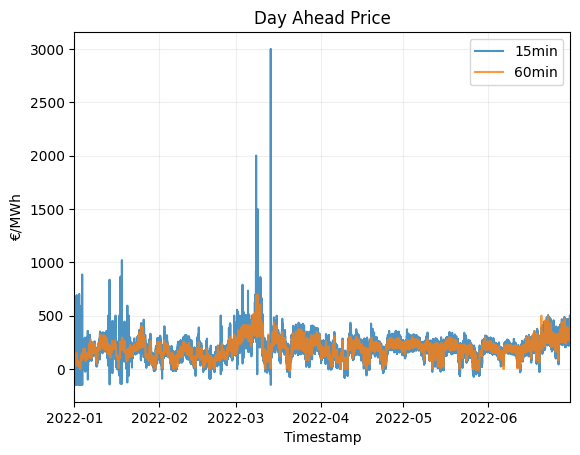

In [4]:
fig, ax = plt.subplots()
sns.lineplot(
    data=dh.fifteen_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8,
    drawstyle='steps-post', 
    label="15min"
)
sns.lineplot(
    data=dh.hourly_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="60min"
)
ax.grid(alpha=0.2)
ax.set_xlim([dh.hourly_df.start_mtu.min(), dh.hourly_df.start_mtu.max()])
ax.set_xlabel("Timestamp")
ax.set_ylabel("€/MWh")
ax.set_title("Day Ahead Price")

Text(0.5, 1.0, 'Average deviation from mean')

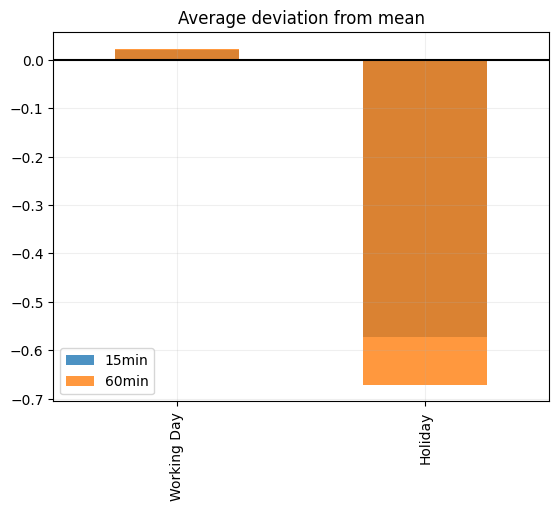

In [5]:
fig, ax = plt.subplots()
dh.fifteen_df.groupby('is_holiday')['normalized_price'].mean().plot.bar(ax=ax, color="C0", alpha=0.8, label="15min")
dh.hourly_df.groupby('is_holiday')['normalized_price'].mean().plot.bar(ax=ax, color="C1", alpha=0.8, label="60min")
ax.legend()
ax.grid(alpha=0.2)
ax.axhline(0.,c='black')
ax.set_xticklabels(['Working Day', 'Holiday'])
ax.set_xlabel("")
ax.set_title("Average deviation from mean")

In [6]:
fifteen_aggr_month = dh.fifteen_df.groupby('month')['normalized_price'].mean()
hourly_aggr_month = dh.hourly_df.groupby('month')['normalized_price'].mean()

In [7]:
corr_month = scipy.stats.pearsonr(fifteen_aggr_month, hourly_aggr_month)
print(f"Correlation of time series at month level: {corr_month.statistic:.3f}")

Correlation of time series at month level: 0.999


In [8]:
fifteen_aggr_week = dh.fifteen_df.groupby('month')['normalized_price'].mean()
hourly_aggr_week = dh.hourly_df.groupby('month')['normalized_price'].mean()

In [9]:
corr_week = scipy.stats.pearsonr(fifteen_aggr_week, hourly_aggr_week)
print(f"Correlation of time series at week level: {corr_week.statistic:.3f}")

Correlation of time series at week level: 0.999


Text(0.5, 1.0, 'Average deviation from mean')

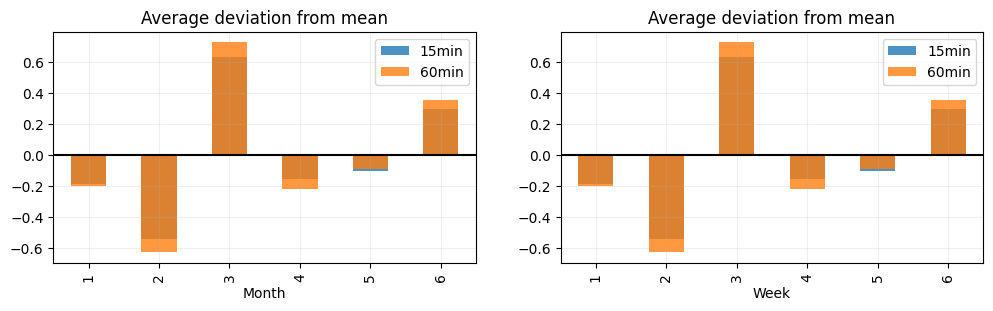

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
fifteen_aggr_month.plot.bar(ax=ax[0], color="C0", alpha=0.8, label="15min")
hourly_aggr_month.plot.bar(ax=ax[0], color="C1", alpha=0.8, label="60min")
ax[0].legend()
ax[0].grid(alpha=0.2)
ax[0].axhline(0.,c='black')
ax[0].set_xlabel("Month")
ax[0].set_title("Average deviation from mean")

fifteen_aggr_week.plot.bar(ax=ax[1], color="C0", alpha=0.8, label="15min")
hourly_aggr_week.plot.bar(ax=ax[1], color="C1", alpha=0.8, label="60min")
ax[1].legend()
ax[1].grid(alpha=0.2)
ax[1].axhline(0.,c='black')
#ax.set_ylim([-0.6,0.6])
ax[1].set_xlabel("Week")
ax[1].set_title("Average deviation from mean")

### 1.2 Visually inspect one month of data.

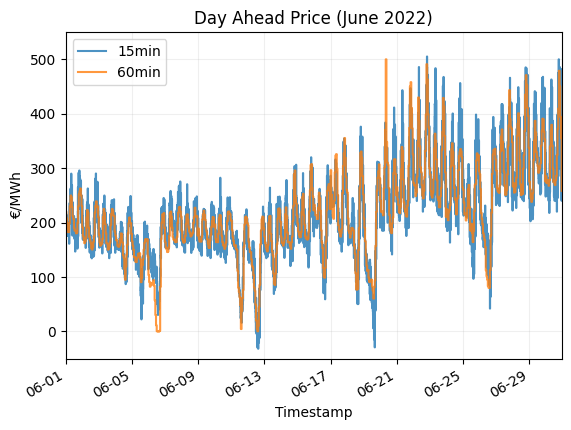

In [11]:
fig, ax = plt.subplots()
sns.lineplot(
    data=dh.fifteen_df,
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8,
    drawstyle='steps-post', 
    label="15min"
)
sns.lineplot(
    data=dh.hourly_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="60min"
)
ax.grid(alpha=0.2)
ax.set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-30 23:00"]))
ax.set_ylim([-50,550])
ax.set_xlabel("Timestamp")
ax.set_ylabel("€/MWh")
ax.set_title("Day Ahead Price (June 2022)")
date_formatter = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()

In [12]:
fifteen_aggr_day = dh.fifteen_df.groupby('day_of_month')['normalized_price'].mean()
hourly_aggr_day = dh.hourly_df.groupby('day_of_month')['normalized_price'].mean()

In [13]:
corr_day = scipy.stats.pearsonr(fifteen_aggr_day, hourly_aggr_day)
print(f"Correlation of time series at week level: {corr_day.statistic:.3f}")

Correlation of time series at week level: 0.967


Text(0.5, 1.0, 'Average deviation from mean')

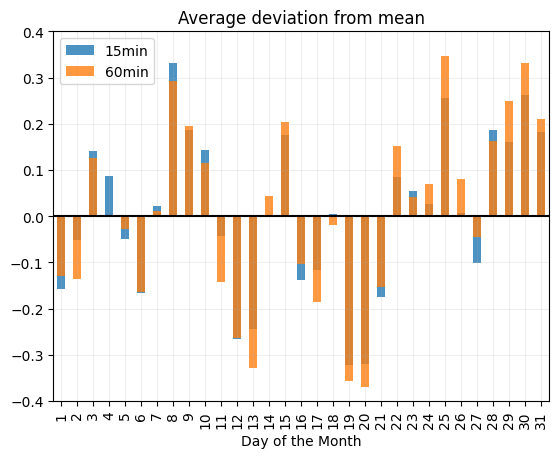

In [14]:
fig, ax = plt.subplots()
fifteen_aggr_day.plot.bar(ax=ax, color="C0", alpha=0.8, label="15min")
hourly_aggr_day.plot.bar(ax=ax, color="C1", alpha=0.8, label="60min")
ax.legend()
ax.grid(alpha=0.2)
ax.axhline(0.,c='black')
ax.set_ylim([-0.4,0.4])
ax.set_xlabel("Day of the Month")
ax.set_title("Average deviation from mean")

### 1.3 Visually inspect one week of data (Mo-Su).

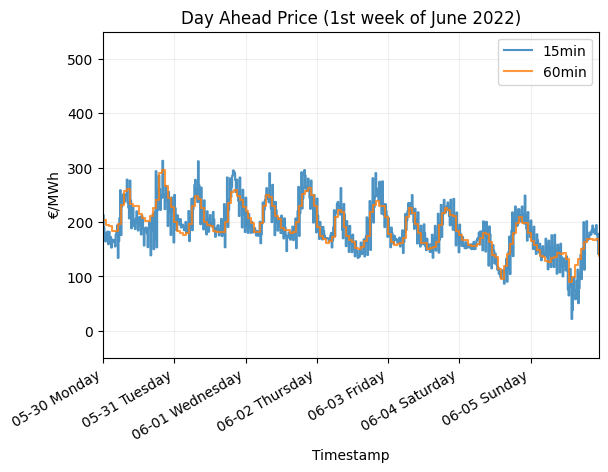

In [15]:
fig, ax = plt.subplots()
sns.lineplot(
    data=dh.fifteen_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8,
    drawstyle='steps-post', 
    label="15min"
)
sns.lineplot(
    data=dh.hourly_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="60min"
)
ax.grid(alpha=0.2)
ax.set_xlim(pd.to_datetime(["2022-05-30 00:00", "2022-06-05 23:00"]))
ax.set_ylim([-50,550])
ax.set_xlabel("Timestamp")
ax.set_ylabel("€/MWh")
ax.set_title("Day Ahead Price (1st week of June 2022)")
date_formatter = mdates.DateFormatter('%m-%d %A')
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()

In [16]:
fifteen_aggr_day_of_week = dh.fifteen_df.groupby('day_of_week')['normalized_price'].mean()
hourly_aggr_day_of_week = dh.hourly_df.groupby('day_of_week')['normalized_price'].mean()

In [17]:
corr_day_of_week = scipy.stats.pearsonr(fifteen_aggr_day_of_week, hourly_aggr_day_of_week)
print(f"Correlation of time series at week level: {corr_day_of_week.statistic:.3f}")

Correlation of time series at week level: 0.998


Text(0.5, 1.0, 'Average deviation from mean')

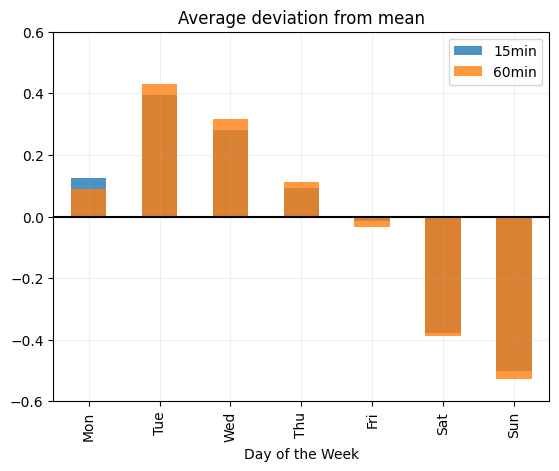

In [18]:
fig, ax = plt.subplots()
fifteen_aggr_day_of_week.plot.bar(ax=ax, color="C0", alpha=0.8, label="15min")
hourly_aggr_day_of_week.plot.bar(ax=ax, color="C1", alpha=0.8, label="60min")
ax.legend()
ax.grid(alpha=0.2)
ax.axhline(0.,c='black')
ax.set_ylim([-0.6,0.6])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel("Day of the Week")
ax.set_title("Average deviation from mean")

### 1.4 Visually inspect one day of data.

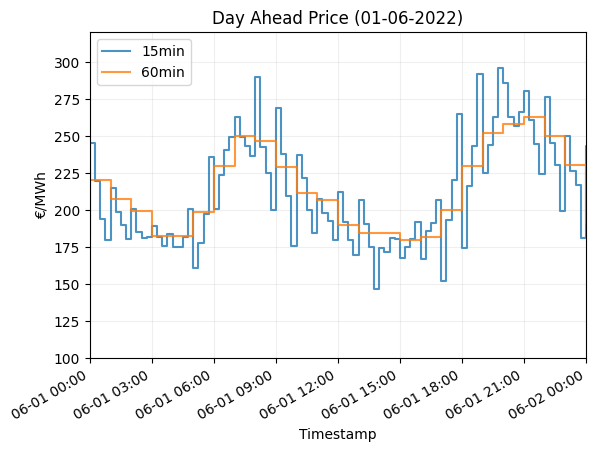

In [19]:
fig, ax = plt.subplots()
sns.lineplot(
    data=dh.fifteen_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8,
    drawstyle='steps-post', 
    label="15min"
)
sns.lineplot(
    data=dh.hourly_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="60min"
)
ax.grid(alpha=0.2)
ax.set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-02 00:00"]))
ax.set_ylim([100,320])
ax.set_xlabel("Timestamp")
ax.set_ylabel("€/MWh")
ax.set_title("Day Ahead Price (01-06-2022)")
date_formatter = mdates.DateFormatter('%m-%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()

In [20]:
fifteen_aggr = dh.fifteen_df.groupby(['hour', 'minute'])[['normalized_price']].mean()
hourly_aggr = dh.hourly_df.groupby('hour')[['normalized_price']].mean()

Text(0.5, 1.0, 'Average deviation from mean')

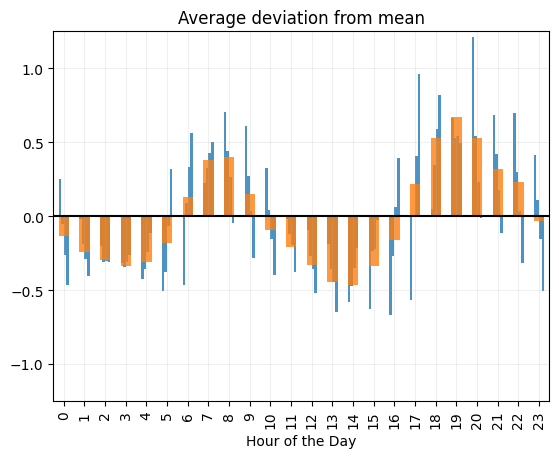

In [21]:
fig, ax = plt.subplots()
fifteen_aggr.unstack().plot.bar(ax=ax, color="C0", alpha=0.8, label="15min")
hourly_aggr.plot.bar(ax=ax, color="C1", alpha=0.8, label="60min")
ax.grid(alpha=0.2)
ax.axhline(0.,c='black')
ax.set_ylim([-1.25, 1.25])
ax.get_legend().remove()
ax.set_xlabel("Hour of the Day")
ax.set_title("Average deviation from mean")

### 1.5 Summary

- The two time series (15min and 60min) show a similar general behavior, confirmed by the correlation factors being close to one at all levels of aggregation.
- The 15min time series shows an higher volatility.
- The size of the sample does not permit to observe significant long-term seasonal effects (quarterly, monthly, etc.) because of lack of statistic.
- Prices during holidays are significantly lower that during working days.
- A clear weekly pattern is visible, with prices relatively lower during weekends (Sat, Sun) than during the week.
- A clear double-peaked daily pattern is visible, with higher prices in the mornings (6 to 9) and in the evenings (17 to 22).
- The 15min data might show a trend behaviour in the single hours units, with recurring peaks/valleys at the beginning of the hour unit.

## 2. Distribution of Prices

### 2.1 Histograms

Text(1010, 0.025, '60min\n-----------\nMin: -19.04\nMax: 700.00\nMean: 185.81\nMedian: 189.00\nStdDev: 90.65')

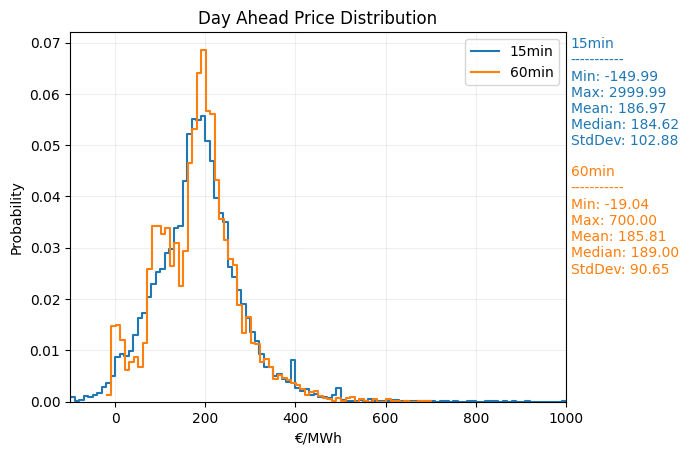

In [22]:
fig, ax = plt.subplots()
sns.histplot(
    data=dh.fifteen_df, 
    x='price',
    binwidth=10,
    ax=ax, 
    label="15min",
    stat="probability",
    element='step',
    fill=False
)
sns.histplot(
    data=dh.hourly_df, 
    x='price',
    binwidth=10,
    ax=ax, 
    label="60min",
    stat="probability",
    element='step',
    fill=False
)
ax.legend()
ax.grid(alpha=0.2)
ax.set_xlim([-100,1000])
ax.set_xlabel("€/MWh")
ax.set_title("Day Ahead Price Distribution")
ax.text(
    1010, 
    0.05,
    "15min\n-----------\n"+\
    f"Min: {dh.fifteen_df['price'].min():.2f}\n"+\
    f"Max: {dh.fifteen_df['price'].max():.2f}\n"+\
    f"Mean: {dh.fifteen_df['price'].mean():.2f}\n"+\
    f"Median: {dh.fifteen_df['price'].median():.2f}\n"+\
    f"StdDev: {dh.fifteen_df['price'].std():.2f}",
    fontsize=10,
    color="C0"
)
ax.text(
    1010, 
    0.025,
    "60min\n-----------\n"+\
    f"Min: {dh.hourly_df['price'].min():.2f}\n"+\
    f"Max: {dh.hourly_df['price'].max():.2f}\n"+\
    f"Mean: {dh.hourly_df['price'].mean():.2f}\n"+\
    f"Median: {dh.hourly_df['price'].median():.2f}\n"+\
    f"StdDev: {dh.hourly_df['price'].std():.2f}",    fontsize=10,
    color="C1"
)

In [23]:
print(f"K-S Test p-value: {scipy.stats.kstest(dh.hourly_df['price'], dh.fifteen_df['price']).pvalue}")

K-S Test p-value: 0.0007605404220022771


### 2.2 Summary

- The higher volatility of the 15min timeseries is confirmed by the statistical quantities (lower min, higher max, larger StdDev)
- The two distributions are significantly different from a K-S test.
- The 60min timeseries is less smooth, with a seemingly multimodal domain with peaks around 0, 100 and 200 €/MWh

## 3. Standard Time Series tests

### 3.1 Results of Dickey-Fuller Test
Series are stationary

15min:

In [62]:
fifteen_ad = pd.Series(
    adfuller(dh.fifteen_df['price'])[0:4], 
    index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used']
)
print(fifteen_ad)

Test Statistic                -5.882267e+00
p-value                        3.058680e-07
# of Lags Used                 4.400000e+01
Number of Observations Used    1.733100e+04
dtype: float64


60min:

In [63]:
hourly_ad = pd.Series(
    adfuller(dh.hourly_df['price'])[0:4], 
    index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used']
)
print(hourly_ad)

Test Statistic                -6.909327e+00
p-value                        1.223875e-09
# of Lags Used                 2.400000e+01
Number of Observations Used    4.319000e+03
dtype: float64


### 3.2 Autocorrelation and Partial Autocorrelation

#### 15min:

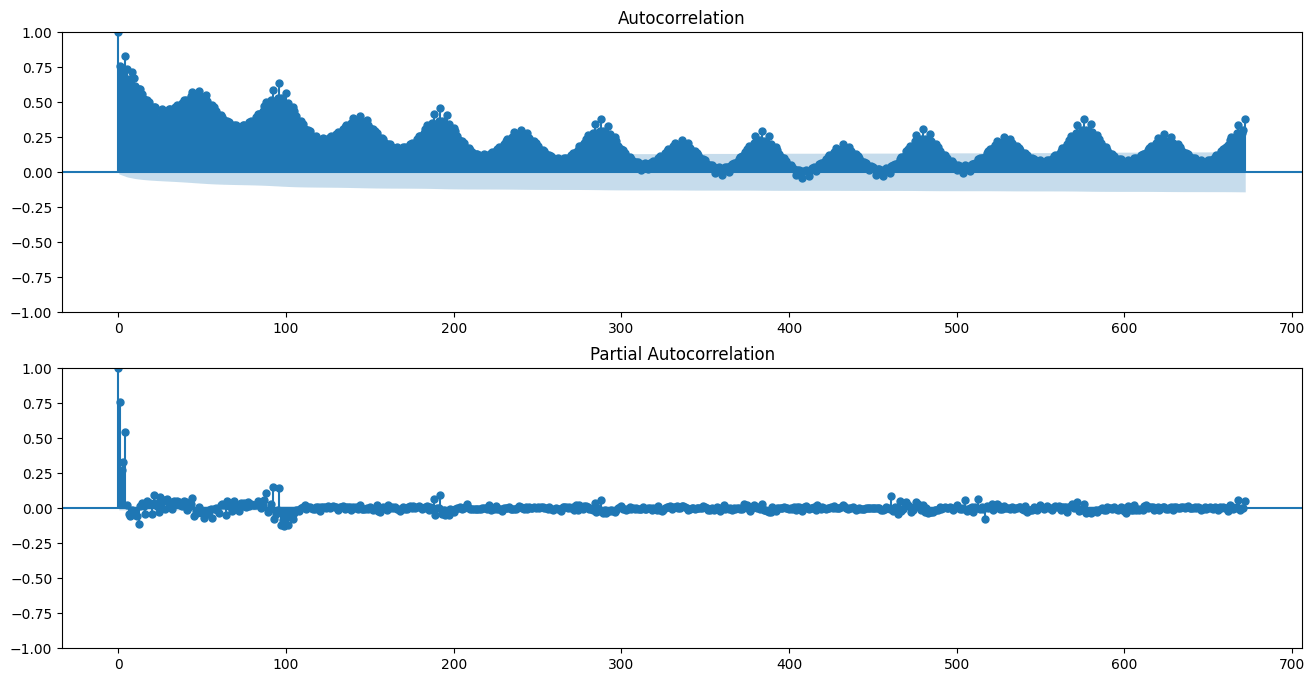

In [54]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
plot_acf(dh.fifteen_df['price'], lags = 4*24*7, ax=ax[0])
plot_pacf(dh.fifteen_df['price'], lags = 4*24*7, ax=ax[1], method='ywm')
plt.show()

#### 60 min:

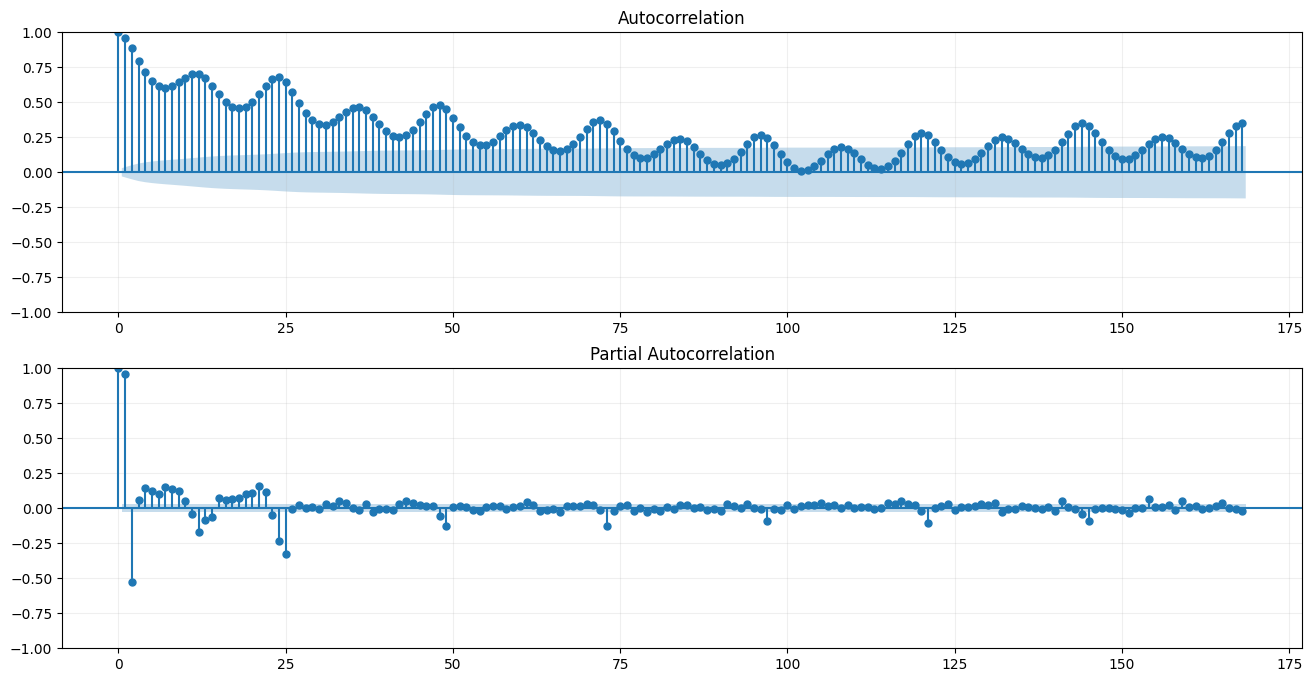

In [133]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
plot_acf(dh.hourly_df['price'], lags = 24*7, ax=ax[0])
plot_pacf(dh.hourly_df['price'], lags = 24*7, ax=ax[1], method='ywm')
plt.show()

### 3.3 Seasonal decomposition

#### 15 min:

In [121]:
decom_fifteen = seasonal_decompose(dh.fifteen_df.set_index('start_mtu').asfreq('15min')['price'], period=4*24*7)

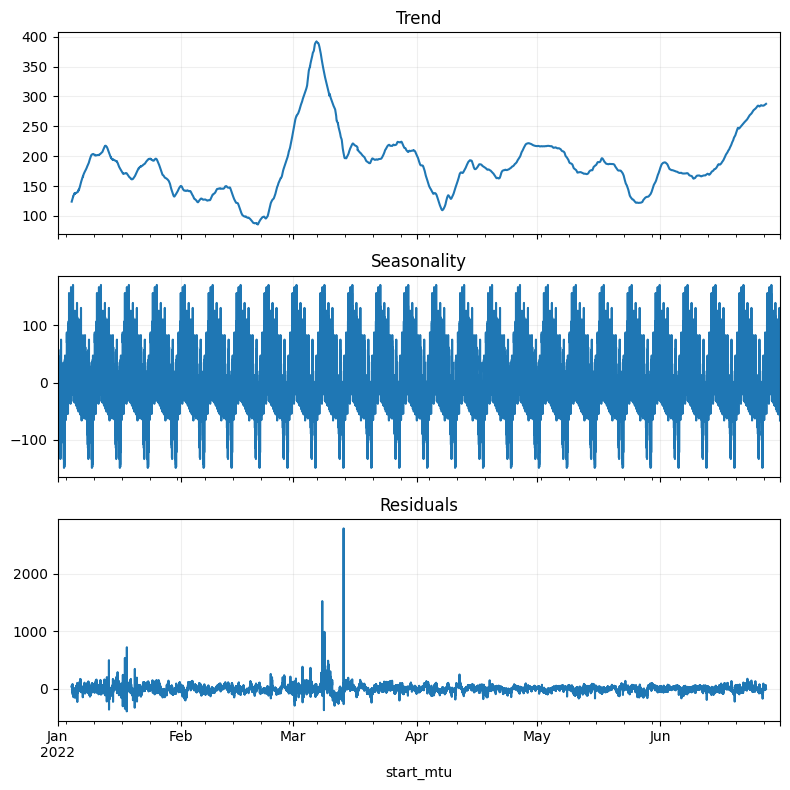

In [136]:
fig, ax = plt.subplots(3,1, figsize=(8,8), sharex=True)
ax[0].set_title("Trend")
decom_fifteen.trend.plot(ax=ax[0])
ax[0].grid(alpha=0.2)
ax[1].set_title("Seasonality")
decom_fifteen.seasonal.plot(ax=ax[1])
ax[1].grid(alpha=0.2)
ax[2].set_title("Residuals")
decom_fifteen.resid.plot(ax=ax[2])
ax[2].grid(alpha=0.2)
plt.tight_layout()

(-300.0, 300.0)

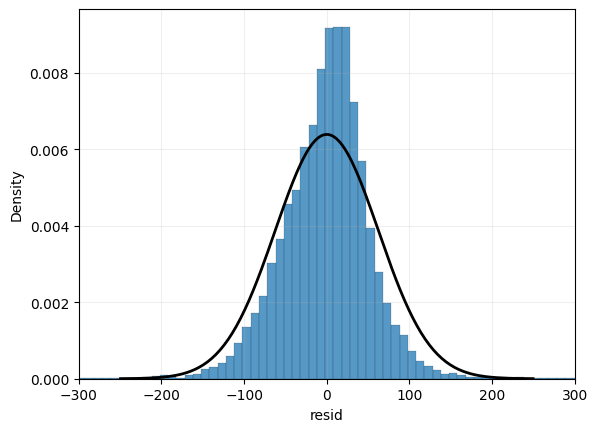

In [137]:
fig, ax = plt.subplots()

def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = scipy.stats.norm.pdf(x, mean, std)
    z = ax.plot(x, p, color, linewidth=2)
    
sns.histplot(
    x=decom_fifteen.resid,
    binwidth=10,
    stat="density"
)
normal(decom_fifteen.resid.mean(), decom_fifteen.resid.std())
ax.grid(alpha=0.2)
ax.set_xlim([-300,300])

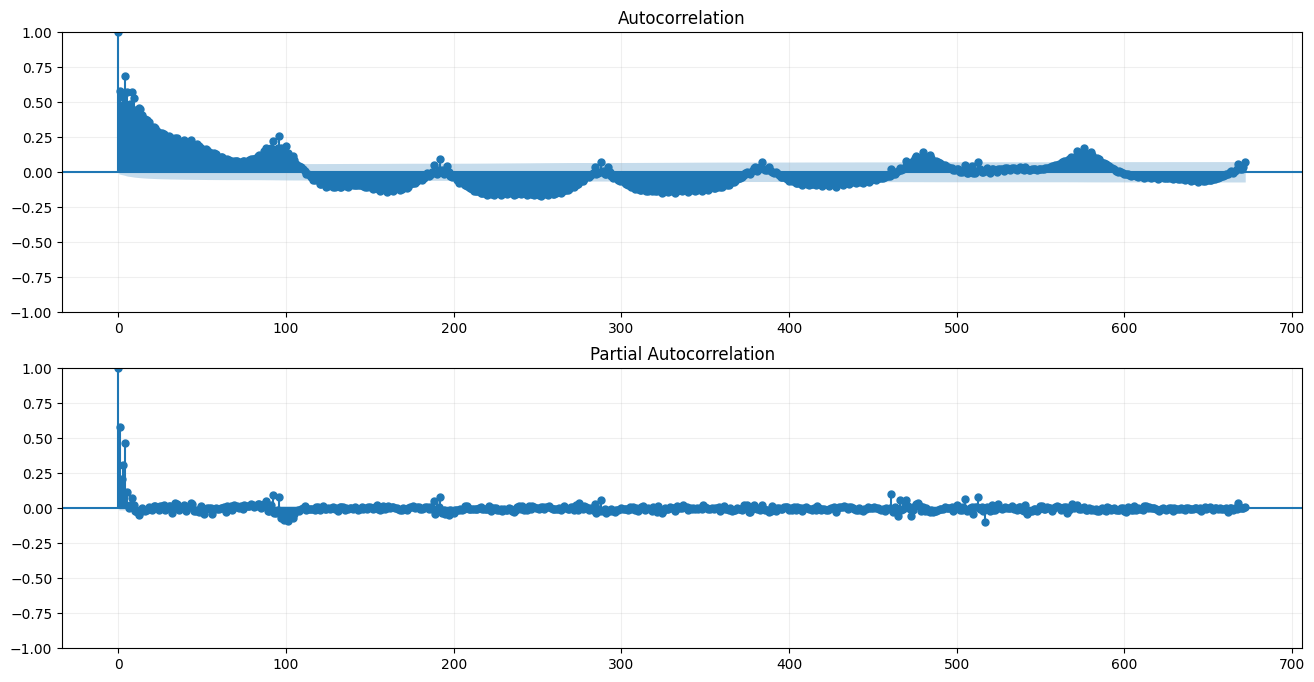

In [138]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
plot_acf(decom_fifteen.resid.dropna(), lags = 4*24*7, ax=ax[0])
plot_pacf(decom_fifteen.resid.dropna(), lags = 4*24*7, ax=ax[1], method='ywm')
plt.show()

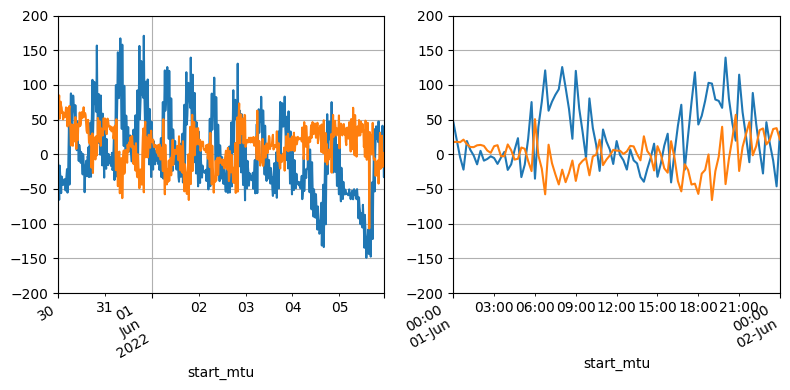

In [144]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
decom_fifteen.seasonal.plot(ax=ax[0])
decom_fifteen.resid.plot(ax=ax[0])
ax[0].grid()
ax[0].set_xlim(pd.to_datetime(["2022-05-30 00:00", "2022-06-05 23:00"]))
ax[0].set_ylim([-200,200])

decom_fifteen.seasonal.plot(ax=ax[1])
decom_fifteen.resid.plot(ax=ax[1])
ax[1].grid()
ax[1].set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-02 00:00"]))
ax[1].set_ylim([-200,200])

fig.autofmt_xdate()

plt.tight_layout()

#### 60min:

In [145]:
decom_hour = seasonal_decompose(dh.hourly_df.set_index('start_mtu').asfreq('1h')['price'], period=24*7)

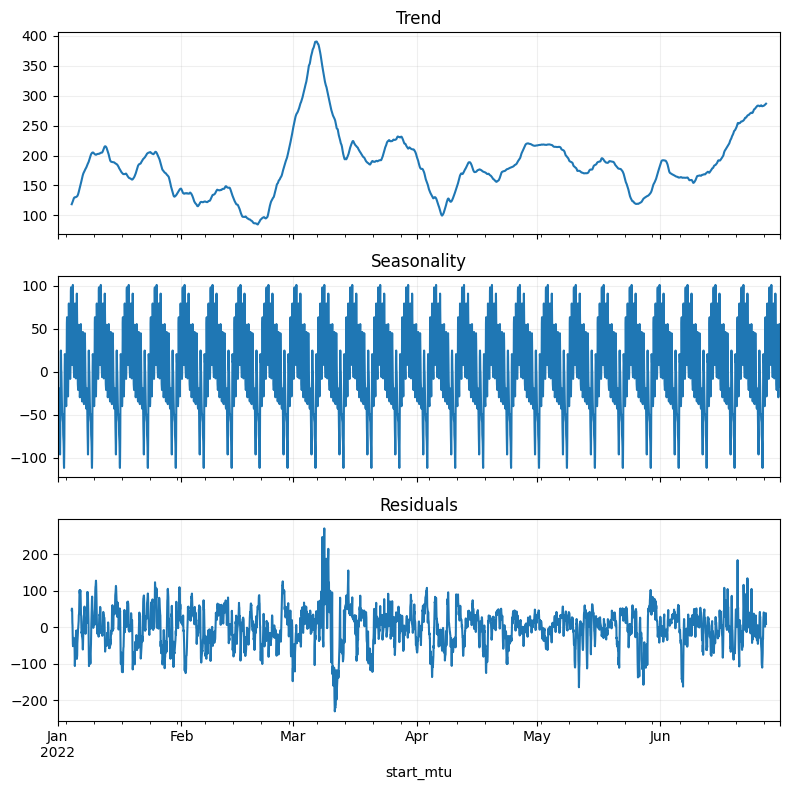

In [146]:
fig, ax = plt.subplots(3,1, figsize=(8,8), sharex=True)
ax[0].set_title("Trend")
decom_hour.trend.plot(ax=ax[0])
ax[0].grid(alpha=0.2)
ax[1].set_title("Seasonality")
decom_hour.seasonal.plot(ax=ax[1])
ax[1].grid(alpha=0.2)
ax[2].set_title("Residuals")
decom_hour.resid.plot(ax=ax[2])
ax[2].grid(alpha=0.2)
plt.tight_layout()

(-300.0, 300.0)

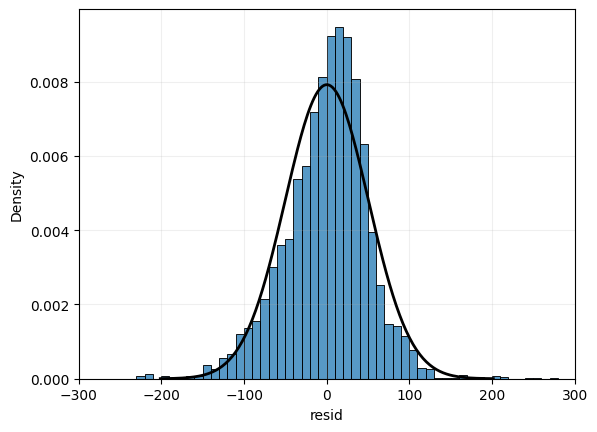

In [147]:
fig, ax = plt.subplots()

sns.histplot(
    x=decom_hour.resid,
    binwidth=10,
    stat="density"
)
normal(decom_hour.resid.mean(), decom_hour.resid.std())
ax.grid(alpha=0.2)
ax.set_xlim([-300,300])

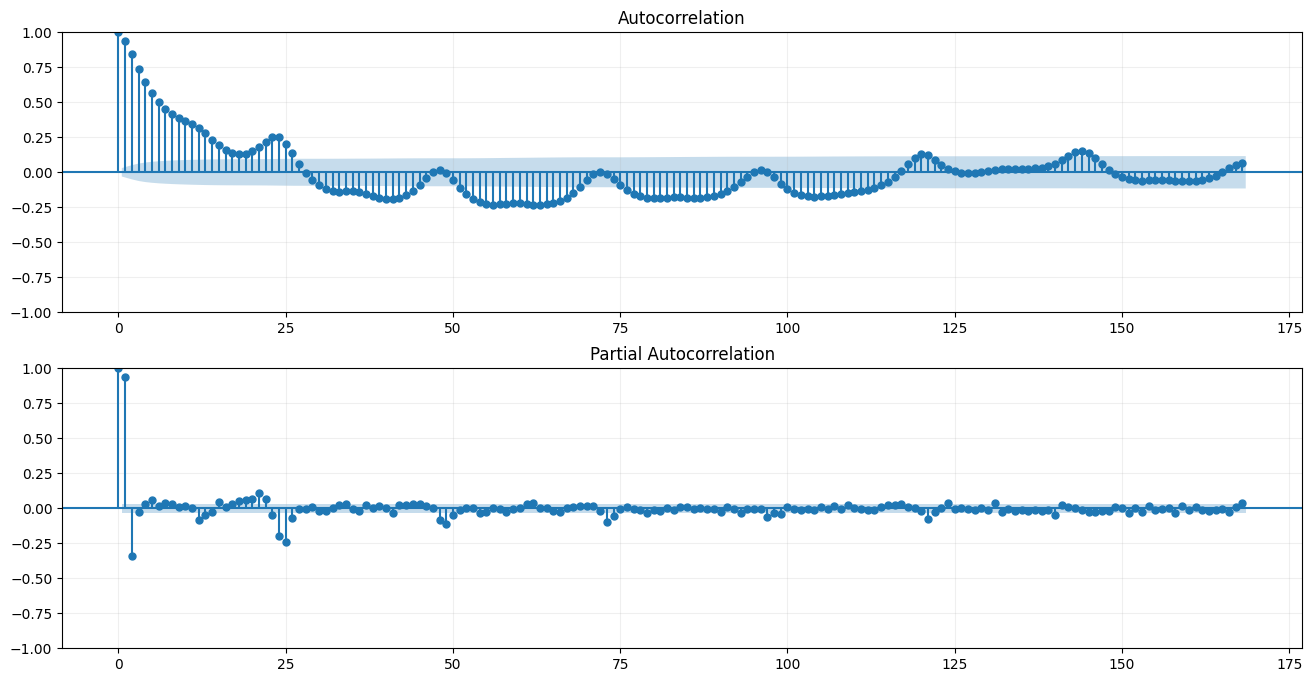

In [148]:
fig, ax = plt.subplots(2,1, figsize=(16,8))
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
plot_acf(decom_hour.resid.dropna(), lags = 24*7, ax=ax[0])
plot_pacf(decom_hour.resid.dropna(), lags = 24*7, ax=ax[1], method='ywm')
plt.show()

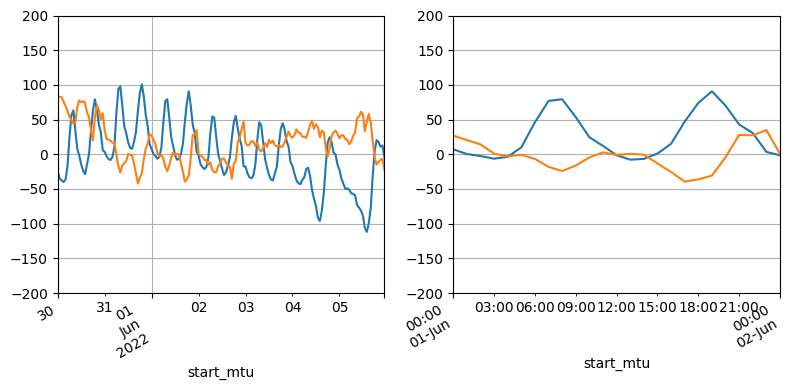

In [154]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
decom_hour.seasonal.plot(ax=ax[0])
decom_hour.resid.plot(ax=ax[0])
ax[0].grid()
ax[0].set_xlim(pd.to_datetime(["2022-05-30 00:00", "2022-06-05 23:00"]))
ax[0].set_ylim([-200,200])

decom_hour.seasonal.plot(ax=ax[1])
decom_hour.resid.plot(ax=ax[1])
ax[1].grid()
ax[1].set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-02 00:00"]))
ax[1].set_ylim([-200,200])

fig.autofmt_xdate()

plt.tight_layout()

## 4. Testing templates

In [149]:
hourly_template = DataHandler.create_template(
    dataframe=dh.hourly_df,
    column='normalized_price',
    grouping_columns=['day_of_week','hour','minute']
)

In [150]:
def get_val_from_template(x, template):
    m_day_of_week = template["day_of_week"] == x["day_of_week"]
    m_hour = template["hour"] == x["hour"]
    m_minute = template["minute"] == x["minute"]
    return template[m_day_of_week & m_hour & m_minute]['normalized_price_tpl_mean'].values[0]

In [151]:
hourly_template_values = dh.hourly_df.apply(lambda x: get_val_from_template(x, hourly_template), axis=1)

In [152]:
test_template = hourly_template_values * dh.hourly_df['price'].std() + dh.hourly_df['price'].mean()

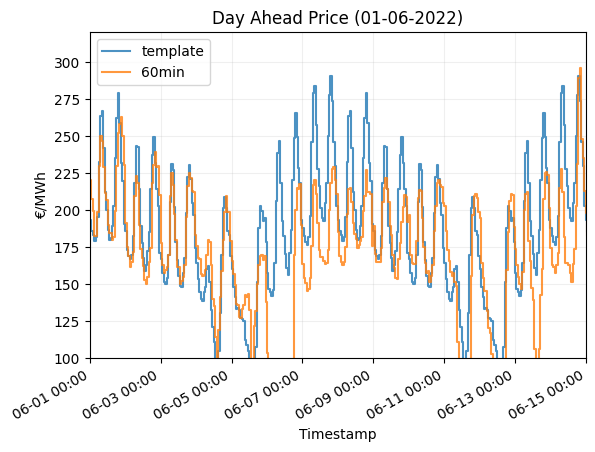

In [153]:
fig, ax = plt.subplots()
sns.lineplot(
    data=dh.hourly_df, 
    x='start_mtu', 
    y=test_template, 
    ax=ax, 
    alpha=0.8,
    drawstyle='steps-post', 
    label="template"
)
sns.lineplot(
    data=dh.hourly_df, 
    x='start_mtu', 
    y='price', 
    ax=ax, 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="60min"
)
ax.grid(alpha=0.2)
ax.set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-15 00:00"]))
ax.set_ylim([100,320])
ax.set_xlabel("Timestamp")
ax.set_ylabel("€/MWh")
ax.set_title("Day Ahead Price (01-06-2022)")
date_formatter = mdates.DateFormatter('%m-%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()